# Model Evaluation

In [23]:
import os
import sys
import pandas as pd
import yaml
import numpy as np
from joblib import load
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

In [3]:
from data.split_data import split_data_by_time

In [4]:
data_path = os.path.join(os.getcwd(), "../data", "processed", "processed_data.csv")
df = pd.read_csv(data_path)
print("Original data shape:", df.shape)

Original data shape: (150000, 45)


In [5]:
constants_path = os.path.join(os.getcwd(), "../src/utils", "constants.yaml")
with open(constants_path, "r") as file:
    constants = yaml.safe_load(file)
FEATURES_TO_USE_AFTER_SELECTION = constants["FEATURES_TO_USE_AFTER_SELECTION"]

In [7]:
X_train, X_test, y_train, y_test = split_data_by_time(
    df
)
# Filter training set to keep only the selected features.
X_train = X_train[FEATURES_TO_USE_AFTER_SELECTION]
X_test = X_test[FEATURES_TO_USE_AFTER_SELECTION]
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (90063, 16)
Test set shape: (59937, 16)


In [13]:
model_path = os.path.join(os.getcwd(), "../artifacts", "best_model_1.pkl")
model = load(model_path)

In [16]:
y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)[:, 1]

In [17]:
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

In [33]:
print("### Training Set Evaluation ###")
print("Classification Report:")
print(classification_report(y_train, y_train_pred))
print("ROC AUC Score:", roc_auc_score(y_train, y_train_proba))

### Training Set Evaluation ###
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     85456
           1       0.86      0.20      0.32      4607

    accuracy                           0.96     90063
   macro avg       0.91      0.60      0.65     90063
weighted avg       0.95      0.96      0.94     90063

ROC AUC Score: 0.8981407553373089


In [32]:
print("### Test Set Evaluation ###")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_test_proba))

### Test Set Evaluation ###
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     57044
           1       0.70      0.14      0.24      2893

    accuracy                           0.96     59937
   macro avg       0.83      0.57      0.61     59937
weighted avg       0.95      0.96      0.94     59937

ROC AUC Score: 0.853130771055911


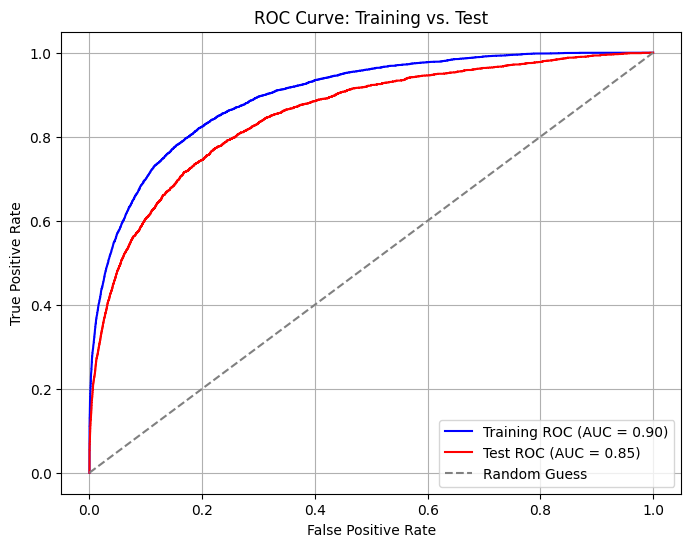

In [24]:
# Compute ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
roc_auc_train = auc(fpr_train, tpr_train)

# Compute ROC curve for test data
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Training ROC (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', label=f'Test ROC (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Training vs. Test')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

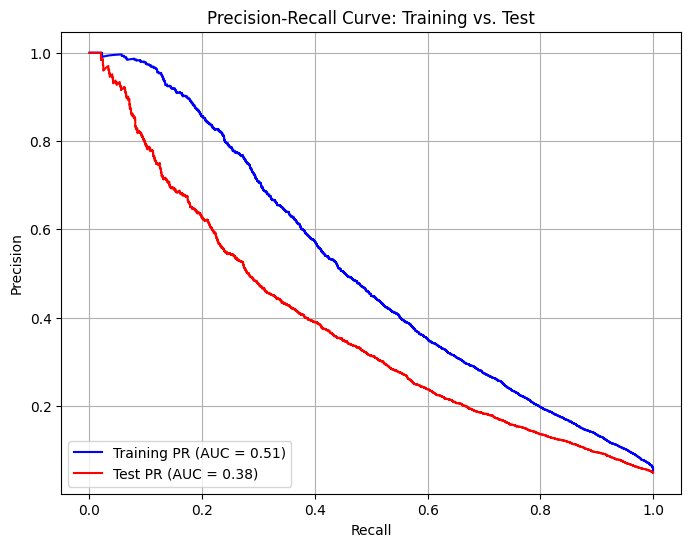

In [25]:
# Compute Precision-Recall curve for training data
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
pr_auc_train = auc(recall_train, precision_train)

# Compute Precision-Recall curve for test data
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)
pr_auc_test = auc(recall_test, precision_test)

# Plot both PR curves
plt.figure(figsize=(8, 6))
plt.plot(recall_train, precision_train, color='blue', label=f'Training PR (AUC = {pr_auc_train:.2f})')
plt.plot(recall_test, precision_test, color='red', label=f'Test PR (AUC = {pr_auc_test:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Training vs. Test')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [28]:
df.columns

Index(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
       'o', 'p', 'fecha', 'monto', 'score', 'fraude', 'ymd', 'week',
       'day_of_week', 'is_weekend', 'hour', 'periodo', 'periodo_num', 'OOT',
       'a_bin', 'g_agrup_simples', 'g_agrup_simples_num', 'i_len',
       'i_special_chars', 'i_special_chars_agrup', 'i_num_count',
       'i_num_count_agrup', 'i_cleaned', 'i_word_original', 'i_word_kit',
       'i_word_gb', 'i_word_ram', 'j_cluster', 'j_cluster_agrup', 'k_bin',
       'o_transformed'],
      dtype='object')

In [29]:
previous_proba = df.loc[X_test.index, "score"] / 100.0

# Compute ROC AUC for the previous model
roc_auc_prev = roc_auc_score(y_test, previous_proba)

# Compute PR curve and PR AUC for the previous model
precision_prev, recall_prev, _ = precision_recall_curve(y_test, previous_proba)
pr_auc_prev = auc(recall_prev, precision_prev)

print("Previous Model Performance:")
print(f"ROC AUC: {roc_auc_prev:.3f}")
print(f"PR AUC: {pr_auc_prev:.3f}")

Previous Model Performance:
ROC AUC: 0.729
PR AUC: 0.255


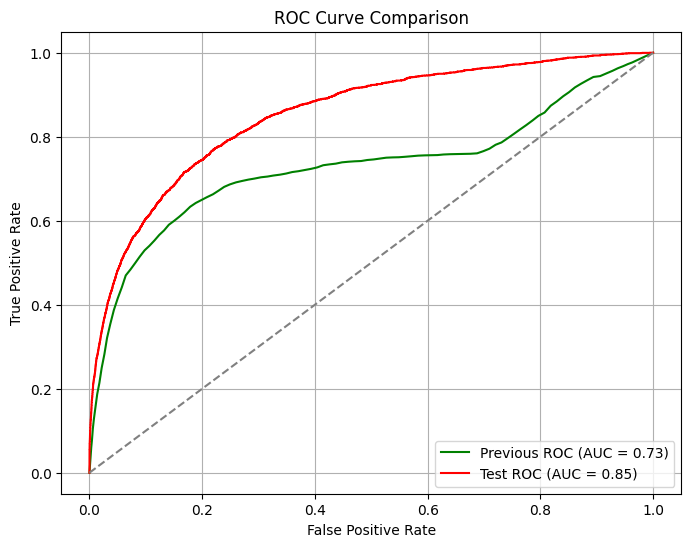

In [30]:
# Plot ROC curves for comparison
fpr_prev, tpr_prev, _ = roc_curve(y_test, previous_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_prev, tpr_prev, color='green', label=f'Previous ROC (AUC = {roc_auc_prev:.2f})')
plt.plot(fpr_test, tpr_test, color='red', label=f'Test ROC (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()   

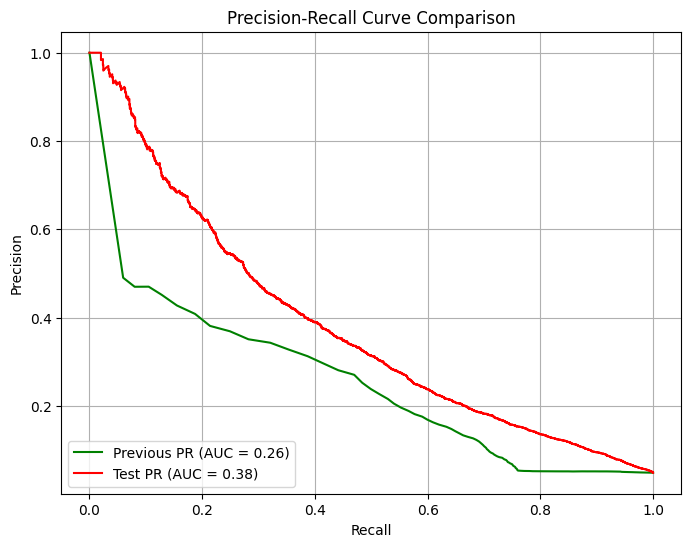

In [31]:
# Plot PR curves for comparison
plt.figure(figsize=(8, 6))
plt.plot(recall_prev, precision_prev, color='green', label=f'Previous PR (AUC = {pr_auc_prev:.2f})')
plt.plot(recall_test, precision_test, color='red', label=f'Test PR (AUC = {pr_auc_test:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

1) Desenvolva um modelo para predizer a variável Fraude (1-Sim, 0-Não).
Quais técnicas testou? Qual selecionou como melhor abordagem? Explique!

* Este desenvolvimento foi iniciado com uma base forte na EDA, isso para garantir estabilidade do modelo e que não perca performance rapidamente em produção
* O modelo escolhido para treinamento foi LightGBM por 3 motivos, o primeiro, que ele é um modelo de boosting, comprovadamente eficaz para casos de target desbalanceada. Já o segundo motivo está relacionado a sua natureza baseada em arvores que facilita no uso de variáveis dentro dele (por isso não foram feitos tratamentos muito rebuscados como normalizar e padronizar as variáveis como é necessário para uma regressão logistica por exemplo). E por último, velocidade, o LightGBM é um modelo conhecido por ser rápido o que facilita muito na hora de treina-lo e também na hora de usa-lo.
* Para seleção de features (além da manual por EDA), foram utilizados modelos bem tradcionais como o Recursive Feature Eliminator e o Boruta, ambos utilizando de um modelo de arvore simples (Random Forest) como base.
* Para tuning foi utilizado o Optuna, ele facilita "tunar" o modelo de maneira mais inteligente e de forma paralela o que o torna muito eficiente.

2) Comparação com o modelo anterior (coluna Score)
Nas figuras acima, utilizamos duas principais métricas para comparar nosso modelo com o anterior:

* ROC AUC (Area Under the ROC Curve): Mede a capacidade de distinguir transações fraudulentas das legítimas em diferentes pontos de corte. Nosso modelo (AUC=0.85) superou o modelo anterior (AUC=0.73).
* PR AUC (Area Under the Precision-Recall Curve): Essencial para cenários desbalanceados, pois mostra como o modelo equilibra a precisão e o recall. Novamente, nosso modelo (AUC=0.38) superou o anterior (AUC=0.26).

3) Garantindo que o desempenho em laboratório seja um proxy para produção

* Divisão temporal (out-of-time split): Treinar em semanas passadas (ex.: 10–14) e testar em semanas futuras (ex.: 15–17) aproxima a realidade de produção.
* Na EDA foram feitas diversas análises para garantir que as variáveis se demonstram estáveis ao longo do tempo e se não, ou foram removidas, ou foram refatoradas para ficarem estáveis.

4) Causas prováveis de discrepância de desempenho em produção

* Drift de dados ou conceito: O comportamento das fraudes e dos clientes pode (e vai) mudar ao longo do tempo (ex.: variável com classes dos produtos ser redefinida pelas áreas de negócio e começarem a vir muitas classes diferentes do que foi visto no treino).
* Diferenças de pipeline e/ou problemas em prod: Se o pipeline de produção for diferente ou em algum momento passar a receber uma das variáveis de forma diferente do que foi passado para treino (ex.: variável com classes dos produtos começar a trazer as classes com uma nomenclatura diferente), o modelo pode performar pior.
* Sazonalidade: Eventos atípicos ou alterações bruscas no comportamento de compra, como grandes ataques de fraude por exemplo, podem impactar a performance.

5) Custo de fraude 10× maior que o bloqueio incorreto

* Ajuste no threshold: Passar a tolerar mais falsos positivos para reduzir falsos negativos, pois a perda com fraude é muito mais custosa, lembrando que pode gerar alto atrito com cliente e é ruim apra imagem da empresa.
* Treino com pesos: É possível ponderar as classes no treinamento conforme os prejuízos. Pode-se colocar exatamente este peso citado no treinamento para garantir que o modelo se adeque a esta necessidade.

6) Queremos encontrar o ponto de corte ideal para o modelo já treinado
apresentado na parte (Score, onde 0 (zero) é o risco mais baixo e 100 (cem) o
mais alto). Sabemos que MELI ganha 10% do valor de um pagamento
aprovado corretamente e a cada fraude aprovada perdemos 100% do valor do
pagamento.Dena o ponto de corte que maximize os lucros do MELI, de
forma que todos os pagamentos com menor Score sejam aprovados e os
maiores sejam rejeitados.


In [35]:
scores = df['score'].values
fraude = df['fraude'].values
montos = df['monto'].values

In [36]:
def compute_profit(cutoff, scores, fraude, montos):
    """
    Calcula o lucro total dado um ponto de corte.
    cutoff: se Score < cutoff, pagamento aprovado; caso contrário, rejeitado.
    """
    # Identifica quais pagamentos são aprovados
    approved = scores < cutoff
    
    # Para pagamentos aprovados, se fraude=0 => +10% do valor; se fraude=1 => -100% do valor
    # Pagamentos rejeitados => 0
    profit = np.where(
        approved, 
        np.where(fraude == 0, 0.1 * montos, -1.0 * montos), 
        0
    )
    return profit.sum()

In [37]:
# Vamos testar todos os possíveis cutoffs (0 a 100)
cutoffs = range(101)
profits = []
for c in cutoffs:
    total_profit = compute_profit(c, scores, fraude, montos)
    profits.append(total_profit)

In [38]:
# Identifica cutoff que maximiza o lucro
profits = np.array(profits)
best_idx = np.argmax(profits)
best_cutoff = cutoffs[best_idx]
best_profit = profits[best_idx]

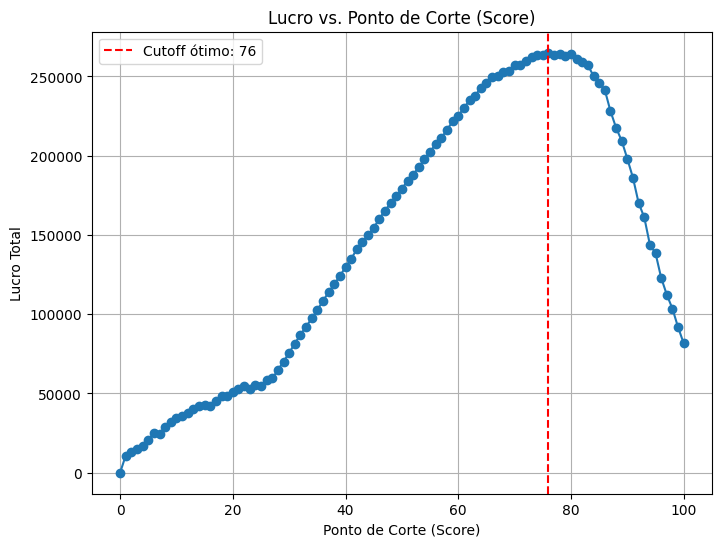

Ponto de corte que maximiza o lucro: 76
Lucro máximo estimado: 264929.07


In [39]:
# Plotando o lucro em função do cutoff
plt.figure(figsize=(8,6))
plt.plot(cutoffs, profits, marker='o')
plt.axvline(x=best_cutoff, color='r', linestyle='--', label=f'Cutoff ótimo: {best_cutoff}')
plt.title('Lucro vs. Ponto de Corte (Score)')
plt.xlabel('Ponto de Corte (Score)')
plt.ylabel('Lucro Total')
plt.legend()
plt.grid(True)
plt.show()

print(f"Ponto de corte que maximiza o lucro: {best_cutoff}")
print(f"Lucro máximo estimado: {best_profit:.2f}")

7) Se o modelo precisar responder online, no menor tempo possível, o que isso
mudaria suas decisões no item 1?

* Modelo já foi pensado para ser mais rápido, as variáveis que pudessem ser simplificadas, e as variáveis muito complexas como o TfIdf acabei optando por não utilizar, para facilitar na criação e tuning do modelo
* Uso do LightGBM como citado anteriormente também facilita na velocidade de resposta

8) Como colocar esse modelo em produção

* notebook 07 + deployment fastapi_app.py

In [71]:
df_homol = df.copy(deep=True)

In [72]:
df_homol['score_homol'] = model.predict_proba(df[FEATURES_TO_USE_AFTER_SELECTION])[:, 1]

In [73]:
df_homol.to_csv('../data/homol/homol_data.csv', index=False)

In [75]:
df_homol.head(2)

,a,b,c,d,e,f,g,h,i,j,...,i_cleaned,i_word_original,i_word_kit,i_word_gb,i_word_ram,j_cluster,j_cluster_agrup,k_bin,o_transformed,score_homol
0,4,0.7685,94436.24,20.0,0.444828,1.0,BR,5,Máquininha Corta Barba Cabelo Peito Perna Pelo...,cat_8d714cd,...,maquininha corta barba cabelo peito perna pelo...,0,0,0,0,1,0,3,2,0.027553
1,4,0.7550,9258.50,1.0,0.000000,33.0,BR,0,Avental Descartavel Manga Longa - 50 Un. Tnt ...,cat_64b574b,...,avental descartavel manga longa 50 un tnt ho...,0,0,0,0,7,0,1,1,0.054370
